# Course Project: Image Segmentation

In this project you will segment neurons in an electron microscope image. You will be given an electron microscope image where a neuron is stained using dense metal precipitates, and your task is to find the approximate outline of the neuron using a sequence of image processing operations that you will implement yourself.

Don't worry if this seems daunting at first, you will develop the solution step by step using small building blocks, and the project progresses at the same pace as the course. During the course you will have time to work on the project and ask questions, and you can already start programming after the first day!

---

## Software prerequisites

This project operates on image data and we will use the following two libraries for functionality not related to the image segmentation itself:

- [Pillow](https://pillow.readthedocs.io/), for reading image files into memory
- [matplotlib](https://matplotlib.org/), for displaying images in this notebook

Please ask your instructors for help with installing these libraries with Anaconda Navigator or with the `pip` command.

---

## Background

A typical analysis task after acquiring microscope images is isolating the structures of interest in the image. This *segmentation* task often  requires user interaction making it time-consuming and error-prone, especially since modern high-end microscopes can easily acquire hundreds of such images in an automated fashion in order to image a 3D volume of a sample. It is thus desirable to have an algorithm to perform this segmentation faster and in a more reproducible fashion.

In this project we will develop an algorithm to segment electron microscopy (EM) images which were stained using the [Golgi staining](https://www.nature.com/articles/s41598-018-37377-x.pdf) technique, where a random neuron is stained with dense metal precipitates. On the EM images these precipitates show up as dark dots inside the neuron. Our goal is to implement a series of image processing steps that detect these dots and group them into larger regions that approximate the shape of the neuron. The figure below shows the input image on the left with the dense black precipitates, and the desired segmentation on the right.

<div>
<img src="images/segm_golgi_stained_em_image.png" width="250"/>
<img src="images/segm_arrow_segment.png" width="40"/>
<img src="images/segm_golgi_stained_em_image_segmented.png" width="250"/>
</div>

Image processing is a very rich field with a large variety of algorithms and techniques. Here, we will focus on one branch of image processing called [mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) and its morphological filtering operations. Morphological filtering concentrates on the geometric structure within images. 

The basic idea is to probe an image with a *structuring element* and to quantify the manner in which the structuring element fits or does not fit within the image. For example, in the figure below we have a binary image (a) and a square structuring element (b), the probe. In some locations the probe fits inside the black object, and in other places it does not. By finding the locations at which the structuring element fits, we derive structural information concerning the object in the image.

<center><img src="images/segm_morphology_probing.png" width="300"/></center>

In the microscope image above one can imagine sliding a circular probe over the image and recording where in the image the probe overlaps with  black particles. This will fill in the gaps between nearby dots, in essence performing a rough segmentation. This idea will be refined below.

The morphological filtering operations that we will program will all operate on binary images ("black and white"). The 4 basic morphological filtering operations are *erosion*, *dilation*, *opening* and *closing*. We will implement three of them.

---

## Part 1: Getting started

As a gentle warm-up exercise, let's look at image thresholding first. Our electron microscope image is a grayscale image, with, say, 256 or 4096 possible intensity values per pixel. For the segmentation task however we only care about the very dark particles in that image. They have pixel intensities near 0. In Part 2 of this project we will write a function that takes an image and returns an new image with only these dense particles and no other 'background'. To do so, we need to determine for each pixel whether or not its intensity is below a certain small threshold value. If it is, the pixel is likely part of the dense particle, if its intensity is higher it is probably not.

Let's solve part of this problem already. Your assignment is to write a function `is_below(val, threshold)` where `val` is the intensity of a pixel, and `threshold` is the threshold intensity of dark particles. The function should return True if the pixel intensity is below the threshold, and False otherwise.

In [1]:
# Solution
def is_below(val, threshold):
    return val < threshold

In [2]:
assert is_below(0, 0) == False, 'Expected: False, got: ' + str(is_below(0, 0))
assert is_below(42, 666) == True, 'Expected: True, got: ' + str(is_below(42, 666))

Great! Now that we know all about Python functions ;-) let's write a somewhat more useful one. Later in this project we will have to create an image of a disk: all pixels inside or on a circle with a given radius will have to be set to one color, and pixels outside the circle to another color. In order to do so, we will need a function that tells us whether a given pixel is inside a disk.

Hence your second assigment is to write a function `is_inside_disk(x, y, radius)` which returns True if the point $(x, y)$ is inside or on a circle with center at $(0,0)$ and with given `radius`, and which returns False otherwise. Remember, the distance from a point with coordinates $(x, y)$ to the origin $(0, 0)$ is given by $\sqrt{x^2 + y^2}$.

In [3]:
# Solution
def is_inside_disk(x, y, radius):
    return x * x + y * y <= radius * radius

In [4]:
assert is_inside_disk(0, 0, 0) == True, 'Expected: True, got: ' + str(is_inside_disk(0, 0, 0))
assert is_inside_disk(1, 0, 0) == False, 'Expected: False, got: ' + str(is_inside_disk(1, 0, 0))
assert is_inside_disk(3, 4, 5) == True, 'Expected: True, got: ' + str(is_inside_disk(3, 4, 5))  # exactly on the disk is considered inside
assert is_inside_disk(1, 1, 2) == True, 'Expected: True, got: ' + str(is_inside_disk(1, 1, 2))
assert is_inside_disk(1, 1, 1) == False, 'Expected: False, got: ' + str(is_inside_disk(1, 1, 1))

Fantastic! That's all for part 1!

---

## Part 2: Image processing

### Data structure for images and structuring elements

One of the most important decisions in any programming task is deciding on what data structures to use to represent the objects that need to be manipulated. In this project these objects are the images and the structuring elements (which are basically also images) that operate on them.

For "real-life" programming tasks on common objects such as images, it is very much advisable to use data structures offered by solid, well-tested Python libraries instead of rolling your own. However, often these libraries require some time to become proficient with them, and in the context of this course we will nevertheless devise our *own* simple image data structure instead.

An image can be viewed as a rectangular matrix of values of pixel intensities. We will represent an image in Python as a list of rows of pixels, and each row as a list of pixel intensity values. So an image will be a list of lists. Suppose we have an image `img` in such a representation. The intensity value of the pixel in the i-th row and the j-th column in the image `img`, is obtained by first retrieving the i-th row in `img`, which is `img[i]`, and then accessing the j-th element in that list, which yields `img[i][j]`. This is illustrated below, with an image with 5 rows and  columns on the left, and its Python representation as a list of lists (with dummy elements) on the right.

<center><img src="images/segm_image_representation.jpg" width="500"/></center>

### Grayscale and binary images

In this project we will deal with both 8-bit per pixel grayscale images (with pixel values ranging from 0 to 255), and binary images (with pixels values 0 or 1). 

*By convention, the value 0 in a grayscale image is displayed as black, 255 as white, and values in between as increasingly bright grays.*

*For our binary images we adopt the convertion that the value 0 is shown as white and represents the empty background, whereas the value 1 will be shown as a black pixel and will represent the presence of an object in the image.*

For your convenience we provide the function `viz(img)` which accepts an image in the representation discussed above (list of lists) and displays it in this notebook. For binary images (which is what we will use most of the time) you can simply pass the image to `viz` for displaying. For grayscale images we do however need to pass the additional named argument `is_binary=False` to signal `viz` that it needs to use the color convention for grayscale images. Don't worry if this confuses you a bit, we normally have provided visualization code for you already in this notebook.

Let's now define a grayscale image and a binary image and demonstrate how to display them.

In [5]:
# Import the function viz() for displaying images in our representation.
%matplotlib inline
from solutions.segmentation import viz

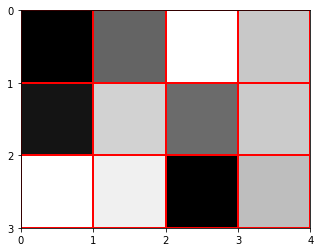

In [6]:
# A grayscale image with 3 rows and 4 columns
img = [[0, 100, 255, 200],
       [20, 210, 107, 203],
       [255, 240, 0, 190]]
viz(img, is_binary=False)

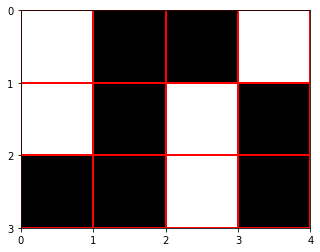

In [7]:
# A binary image with 3 rows and 4 columns
img = [[0, 1, 1, 0],
       [0, 1, 0, 1],
       [1, 1, 0, 1]]
viz(img)

Note how the value 0 is rendered as black in the grayscale image, and was white in the binary image.

### Image dimensions

With all this out of the way we can finally do some more coding! Our first assignment with images is writing a function which finds the dimensions of a given image: given an image `img`, write a function `get_dimensions(img)` which returns a pair `(height, width)` where height is the number of rows, and width the number of columns in the image.

For robustness we will also handle the case of an image without any pixels at all, so with 0 rows and 0 columns. Such a singular image is represented as `[]`. Edge cases are a common source of bugs in programs, so it's important to pay attention to them too.

In [8]:
# Solution
def get_image_dimensions(img):
    height = len(img)
    if height > 0:
        width = len(img[0])
    else:
        width = 0
    return height, width

In [9]:
assert get_image_dimensions([]) == (0, 0)  # edge case, an image without any pixels
assert get_image_dimensions([[0]]) == (1, 1)
assert get_image_dimensions([[0, 1]]) == (1, 2)
assert get_image_dimensions([[0], [1]]) == (2, 1)
assert get_image_dimensions([[0, 0, 0, 0, 0], [1, 2, 3, 4, 5]]) == (2, 5)

### Creating an empty image

For several image operations later in the project it will be convenient if we have a function for constructing "empty" images, so images filled with the pixel intensity of the background.

Write a function `make_empty_image(height, width)` which constructs an image with `height` rows and `width` columns, and where each pixel is set to the value 0.

In [10]:
# Solution
def make_empty_image(height, width):
    img = []
    for i in range(height):
        row = []
        for j in range(width):
            row.append(0)
        img.append(row)
    return img

In [11]:
assert make_empty_image(0, 0) == [], 'Expected: [], got: ' + str(make_empty_image(0, 0))
assert make_empty_image(1, 1) == [[0]], 'Expected: [[0]], got: ' + str(make_empty_image(1, 1))
assert make_empty_image(2, 5) == [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], 'Expected: [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], got: ' + str(make_empty_image(2, 5))

Let's vizualize the output of `make_empty_image()` to confirm that everything works as expected.

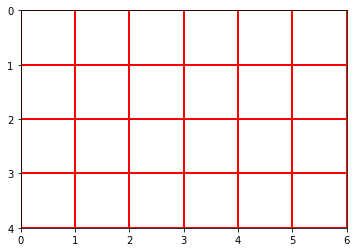

In [12]:
img = make_empty_image(4, 6)
viz(img)

Okay, that looks like an array of empty pixels to me! Not totally stunning yet, but we're making good progress!

### Create a disk-shaped structuring element

We're getting the hang of this stuff! Let's now create a slightly more exciting image. We'll now write a short function to create a disk-shaped structuring element. Remember, structuring elements are actually just images too.

Write a function `make_disk_se(radius)` which takes an integer radius and returns a square image of `2*radius+1` rows and columns. The center of the disk is exactly the middle pixel of the image. The pixel intensities inside the disk are set to 1 and set to 0 everywhere else.

The easiest implementation approach is to first create an empty image of the right dimensions using the function `make_empty_image()` that you have implemented already, and then fill in the correct pixel values. To decide whether or not a pixel is inside the disk, you can use your `is_inside_disk(x, y, radius)` function too! Remember that the center of the disk is in the middle of the image, though!

In [13]:
# Solution
def make_disk_se(radius):
    # Create an empty image of the correct dimensions
    height = 2 * radius + 1
    width = height
    img = make_empty_image(height, width)
    
    # Set pixels inside the disk to 1.
    for i in range(height):
        for j in range(width):
            inside = is_inside_disk(i - radius, j - radius, radius)
            if inside:
                img[i][j] = 1
            else:
                img[i][j] = 0  #  redundant, make_empty_image already did this
                
    return img

In [14]:
assert make_disk_se(0) == [[1]], 'Expected: {[[1]]}, got: ' + str(make_disk_se(0))
assert make_disk_se(1) == [[0, 1, 0], [1, 1, 1], [0, 1, 0]], 'Expected: {[[0, 1, 0], [1, 1, 1], [0, 1, 0]]}, got: ' + str(make_disk_se(1))
assert make_disk_se(3) == [[0, 0, 0, 1, 0, 0, 0], [0, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 0], [0, 0, 0, 1, 0, 0, 0]], 'Expected: {[[0, 0, 0, 1, 0, 0, 0], [0, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 0], [0, 0, 0, 1, 0, 0, 0]]}, got: ' + str(make_disk_se(3))

Let's see what a disk structuring element looks like.

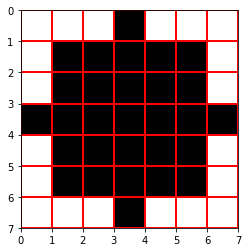

In [15]:
se = make_disk_se(3)
viz(se)

Cool, that's a disk, no!?

We're definitely on the right track here! Before we dig into the real meat of this project, we'll first implement two additional helper functions that deal with images and structuring elements: calculating the **complement** of an image, and **reflecting** a structuring element.

### Image complement

The set-theoretical complement of an image or a structuring element $A$ is denoted $A^c$. We can view an image $A$ as a set of pixels (the black pixels, with value 1) that represents the *inside* of a certain 2-dimensional figure. The complement $A^c$ of that image then represents everything that is *outside* that figure.

<center><img src="images/segm_image_complement.jpg" width="400"/></center>

Calculating the complement of a binary image is easy: the complement image has pixels with value 0 where the input image has pixels with value 1, and vice versa.

Write a function `complement(img)` that returns a new image which is the complement of the input image `img`. Again the easiest approach if to first create an empty image of the correct dimensions (use your `get_image_dimensions()` function), and then iterate over the pixels to set the pixels in this new image to the correct value. Note that since structuring elements are also images, `complement` will work on them too.

In [16]:
# Solution
def complement(img):
    # Make an empty image 'result' of the right dimensions
    height, width = get_image_dimensions(img)
    result = make_empty_image(height, width)
    
    # Now fill in the result with the correct pixel values
    for i in range(height):
        for j in range(width):
            if img[i][j] == 0:
                result[i][j] = 1
            else:
                result[i][j] = 0
                
    return result

In [17]:
assert complement([[0]]) == [[1]], 'Expected: {[[1]]}, got: ' + str(complement([[0]]))
assert complement([[1]]) == [[0]], 'Expected: {[[0]]}, got: ' + str(complement([[1]]))
assert complement([[1, 1, 0], [0, 1, 0]]) == [[0, 0, 1], [1, 0, 1]], 'Expected: {[[0, 0, 1], [1, 0, 1]]}, got: ' + str(complement([[1, 1, 0], [0, 1, 0]]))

Here's an example:

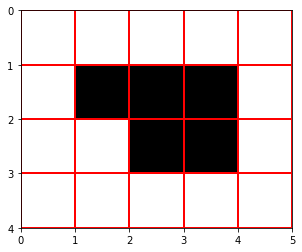

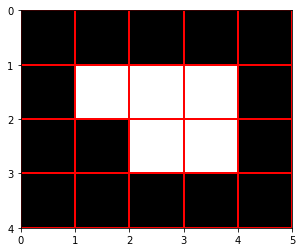

In [18]:
img = [[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0], 
       [0, 0, 1, 1, 0], 
       [0, 0, 0, 0, 0]]
viz(img)
viz(complement(img))

### Reflecting a structuring element

A second *helper* operation we need lateron is the reflection of a structuring element. Let's look into this now.

Suppose $B$ is a structuring element. The reflection of $B$, or the 180 degrees rotation of B around the origin, is denoted $\breve{B}$ and defined as follows:

$$\breve{B} = \{-b : b \in B\} $$

This looks a bit scary but remember it just means to rotate the structuring element (image) around the origin, and by definition the origin of our structuring elements is always the middle pixel of the structuring element. In the example below, the original structuring element $B$ is the fish-like object on the left, and it's reflection $\breve{B}$ is shown on the right.

<center><img src="images/segm_se_reflection.png" width="300"/></center>

We can now write the function `reflect_se(se)` which takes a structuring element (image) `se` as input, and returns a new structuring element (i.e. a new image) which is the reflection of `se`. Again, for simplicity start with an empty image of the correct dimensions, and fill in the correct pixel values.

In [19]:
# Solution
def reflect_se(se):
    # Make an empty image 'result' of the right dimensions
    height, width = get_image_dimensions(se)
    result = make_empty_image(height, width)
    
    # Structuring elements must have a center pixel, so their dimensions must be odd
    assert height % 2 == 1
    assert width % 2 == 1
    
    # Now fill in the result with the correct pixel values
    for i in range(height):
        for j in range(width):
            result[i][j] = se[height-i-1][width-j-1]
            
    return result

In [20]:
assert reflect_se([[1]]) == [[1]], 'Expected: {[[1]]}, got: ' + str(reflect_se([[1]]))
assert reflect_se([[0, 1, 1, 1, 1], [1, 0, 0, 0 ,0], [0, 1, 0, 1, 1]]) == [[1, 1, 0, 1, 0], [0, 0, 0, 0, 1], [1, 1, 1, 1, 0]], 'Expected: {[[0, 1, 0], [0, 0, 1], [0, 1, 1]]}, got: ' + str(reflect_se([[0, 1, 1, 1, 1], [1, 0, 0, 0 ,0], [0, 1, 0, 1, 1]]))

Let's see reflection in action.

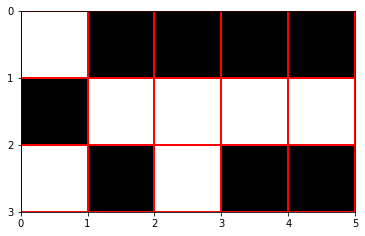

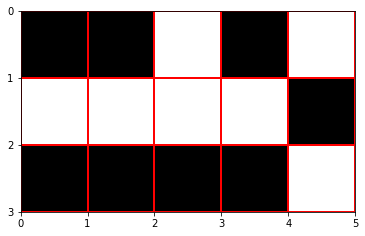

In [21]:
se = [[0, 1, 1, 1, 1],
      [1, 0, 0, 0 ,0],
      [0, 1, 0, 1, 1]]
viz(se)
viz(reflect_se(se))

### Erosion

We've now arrived at the crux of this project, implementing one of the core operations in mathematical morphology: erosion.

In erosion we position the structuring element at each of the pixels in the input image in turn, and record whether or not the structuring element at that position fits inside the object represented by black pixels in the image.

In mathematical notation, the translation of a set $A$ by a point $x$ is denoted by $A_x$ and is defined as

$$ A_x = \{a + x : a \in A\} $$

Note that x is not just a single x-value, it is a 2D displacement (a 2D vector).

In the figure below, we have a structuring element (a) on the left, and its translation (b) on the right.

<center><img src="images/segm_translation.png" width="300"/></center>

The erosion of a set $A$ by a set $B$ is denoted $A \ominus B$ and is defined by

$$A \ominus B = \{ x : B_x \subset A \} $$

In words, an image $A$ eroded by structuring element $B$ is the set of all translations $x$ (the set of all positions in the input image) such that when we position the structuring element at that location, the structuring element is a subset $A$.

In the figure below in (a) the input image is shown in gray, and its erosion in black. The structuring element used is shown in (b). Note that the erosion indicates all the places where the structuring element can be placed so that it remains inside the gray input image (object).

<center><img src="images/segm_erosion.png" width="300"/></center>

Let's now implement erosion! We will break the implementation in two: one part is to position the structuring element over each of the pixels in the input image in turn, and the other is to check whether the structuring element placed at that position 'fits' inside the image.

Write a function `is_subset(img, se, translation)` where `img` is the input image, `se` is a structuring element (which is also an image), and `translation` is a pair of values (row, column) that indicate the pixel in the input image on which to center the structuring element. The function then compares all pixels in the structuring element with the corresponding pixels in the input image. If **no** black (value 1) pixels in the structuring element overlap with empty (value 0) pixels in the input image, the structuring element 'fits' in the image at that position, and `is_subset` returns True, otherwise it returns False.

In [22]:
# Solution
def is_subset(img, se, translation):
    # Get the dimensions of the input image
    img_height, img_width = get_image_dimensions(img)
    
    # Get the dimensions of the structuring element
    se_height, se_width = get_image_dimensions(se)
    
    # Unpack the translation pair into ti, tj (i.e. image row, image column)
    ti, tj = translation
    
    # The *center* of the structuring element 
    # (= the middle pixel of the structuring element)
    # must be placed on the image at position (ti, tj).
    
    # Iterate over each pixel in the structuring element.
    # Translate it and compare it to the pixel in the input image at that location,
    # to see if we can conclude that the structuring element is not a subset.
    # Note also that some pixels in the structuring element might stick outside
    # the input image. We need to check for this and ignore such pixels.
    for i in range(se_height):
        for j in range(se_width):
            row = ti + i - se_height // 2
            col = tj + j - se_width // 2
            if row >= 0 and col >= 0 and col < img_width and row < img_height:
                if img[row][col] == 0 and se[i][j] == 1:
                    return False
    return True

In [23]:
img = [[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0], 
       [0, 0, 1, 1, 0], 
       [0, 0, 0, 0, 0]]
se = [[0, 0, 0],
      [1, 1, 0],
      [0, 1, 0]]
assert is_subset([[1]], [[1]], (0, 0)) == True
assert is_subset([[0]], [[1]], (0, 0)) == False
assert is_subset(img, se, (0, 0)) == False, 'Expected: False, got: ' + str(is_subset(img, se, (0, 0)))
assert is_subset(img, se, (1, 2)) == True, 'Expected: True, got: ' + str(is_subset(img, se, (1, 2)))
assert is_subset(img, se, (1, 3)) == True, 'Expected: True, got: ' + str(is_subset(img, se, (1, 3)))
assert is_subset(img, se, (3, 4)) == False, 'Expected: False, got: ' + str(is_subset(img, se, (3, 4)))

The actual erosion function is now straightforward. Write a function `erode_image(img, se)` which loops over all pixels in the input image `img` and checks whether a structuring element at that position is a subset of `img`.

In [24]:
# Solution
def erode_image(img, se):
    # Create an empty result image of the correct dimensions
    height, width = get_image_dimensions(img)
    result = make_empty_image(height, width)
    
    # Position the structuring element over each of the pixels
    # in the input image in turn, and remember in
    for i in range(height):
        for j in range(width):
            translation = (i, j)   # the translation position is a pair of image coordinates
            if is_subset(img, se, translation):
                result[i][j] = 1
            else:
                result[i][j] = 0
    return result

In [25]:
img = [[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0], 
       [0, 0, 1, 1, 0], 
       [0, 0, 0, 0, 0]]
se = [[0, 0, 0],
      [1, 1, 0],
      [0, 1, 0]]
assert erode_image(img, se) == [[0, 0, 0, 0, 0], [0, 0, 1, 1, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], 'Expected: {[[0, 0, 0, 0, 0], [0, 0, 1, 1, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]}, got: ' + str(erode_image(img, se))

That was a bit hairy! But we've finished the hardest part. The rest of the project is mostly assembling the building blocks we've implemented already. I promise!

### Dilation

The next morphological operation we need is dilation. In a sense it is "the opposite" (the dual) of erosion.

The figure below shows dilation as the dual of erosion (dilation as expansion). Shown on the left (a) is the input image in black, and its dilation in gray. On the right (b) is the structuring element used for the dilation.

<center><img src="images/segm_dilation.png" width="300"/></center>

The dilation of $A$ by $B$ is denoted $A \oplus B$ and is defined by

$$ A \oplus B = (A^c \ominus \breve{B})^c$$

where $A^c$ denotes the complement of A.

To dilate $A$ by $B$, $B$ is reflected (i.e. rotated around the origin) to obtain $\breve{B}$, $A^c$ is eroded by $\breve{B}$, and then the complement of the erosion is taken.

Because of all our hard preliminary work, implementing dilation is now trivial! Write a function `dilate_image(img, se)` which takes an input image `img` that must be dilated by structuring element `se`, and which returns the resulting dilated image. The implementation is simply the composition of a couple of functions you defined earlier in this project.

In [26]:
# Solution
def dilate_image(img, se):
    return complement(erode_image(complement(img), reflect_se(se)))

In [27]:
img = [[1, 0, 1, 0, 0],
       [0, 1, 1, 1, 0], 
       [0, 0, 1, 1, 0], 
       [1, 1, 1, 1, 0], 
       [0, 0, 1, 1, 0]]
se = [[0, 0, 0],
      [1, 1, 0],
      [0, 1, 0]]
assert dilate_image([[1]], [[1]]) == [[1]], 'Expected: {[[1]]}, got: ' + str(dilate_image([[1]], [[1]]))
assert dilate_image(img, se) == [[1, 1, 1, 0, 0],[1, 1, 1, 1, 0], [0, 1, 1, 1, 0],[1, 1, 1, 1, 0], [1, 1, 1, 1, 0]], 'Expected: {[[1, 1, 1, 0, 0],[1, 1, 1, 1, 0], [0, 1, 1, 1, 0], [1, 1, 1, 1, 0], [1, 1, 1, 1, 0]]}, got: ' + str(erode_image(img, se))

### Closing

Finally, we arrive at the last morphological operation that we need to implement: *closing*. It is defined as a dilation followed by an erosion with the same structuring element. The idea is that dilation first fills in small holes and indentations in an image, but also tends to grow the image towards the outside. By following dilation with erosion, the indentations remain filled, but we "undo" the general outward growth of the image. We will use closing as a core component in the segmentation algorithm in Part 3 of the project.

In the figure below: (a) disk structuring element, (b) input image, (c) dilation, (d) closing.

<center><img src="images/segm_dilation_vs_closing.png" width="500"/></center>

In mathematical notation:

 The **closing** of A by B is denoted by $A \bullet B$ and is defined as

$$A \bullet B = (A \oplus B) \ominus B$$

The implementation of closing is once again trivial given the building blocks we already implemented. Write a function `close_image(img, se)` which implements closing by first dilating the image and then eroding it.

In [28]:
# Solution
def close_image(img, se):
    return erode_image(dilate_image(img, se), se)

In [29]:
img = [[0,0,0,0,0,0],
       [0,1,0,1,0,0],
       [0,1,1,0,1,0],
       [0,1,1,1,0,0],
       [0,0,0,0,0,0]]
se = [[0,0,0],
      [0,1,0],
      [0,1,1]]
assert close_image(img, se) == [[0, 0, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0], [0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 0, 0], [0, 1, 1, 1, 1, 0]], 'Expected: {[[0, 0, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0], [0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 0, 0], [0, 1, 1, 1, 1, 0]]}, got: ' + str(close_image(img, se))

The fact that these implementations are simple compositions of other functions is not coincidental, but a direct consequence of the fact that these morphological operations form an algebra with an elegant and clearly defined mathematical structure.

### Comparing erosion, dilation and closing

As an example of erosion, dilation and closing, let's have a look what these operations have as effect on the image of a letter g.

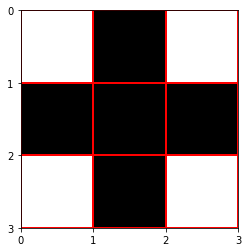

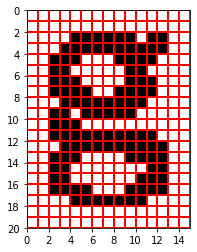

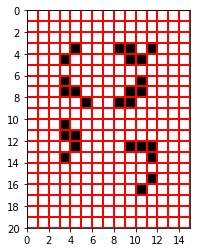

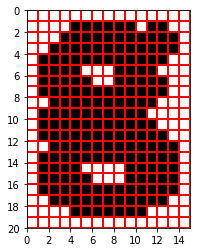

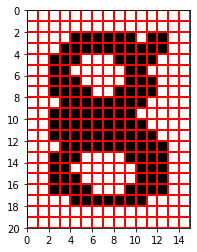

In [30]:
# A letter g
img = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,1,1,1,1,1,1,0,1,1,0,0],
       [0,0,0,1,1,1,1,1,1,1,1,1,1,0,0],
       [0,0,1,1,1,0,0,0,1,1,1,1,0,0,0],
       [0,0,1,1,0,0,0,0,0,1,1,0,0,0,0],
       [0,0,1,1,1,0,0,0,0,1,1,1,0,0,0],
       [0,0,1,1,1,1,0,0,1,1,1,1,0,0,0],
       [0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
       [0,0,1,1,0,1,1,1,1,1,0,0,0,0,0],
       [0,0,1,1,1,0,0,0,0,0,0,0,0,0,0],
       [0,0,1,1,1,1,1,1,1,1,1,1,0,0,0],
       [0,0,0,1,1,1,1,1,1,1,1,1,1,0,0],
       [0,0,1,1,1,0,0,0,0,1,1,1,1,0,0],
       [0,0,1,1,0,0,0,0,0,0,0,1,1,0,0],
       [0,0,1,1,0,0,0,0,0,0,1,1,1,0,0],
       [0,0,1,1,1,1,0,0,0,1,1,1,1,0,0],
       [0,0,0,0,1,1,1,1,1,1,1,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
       
se = [[0, 1, 0],
      [1, 1, 1],
      [0, 1, 0]]

viz(se)
viz(img)
viz(erode_image(img, se))
viz(dilate_image(img, se))
viz(close_image(img, se))

Note how dilation filled the small hole and the groove between the top and bottom halves of the letter g, but also made the letter thicker. The closing operation closed these gaps too, but leaves the letter roughly the same thickness.

It is for this behaviour that we will use the *closing* morphological filter operation to merge nearby metal precipitates in our Golgi stained images into larger blobs (approximately) corresponding to the shape of the neurons that they stain.

We now have all the tools for tackling our original problem: image segmentation. Let's move on to part 3 of the project!

---

## Part 3: Image segmentation

In the last part of the project we will perform the actual segmentation of the electron microscopy image.

We need one final helper function, which we already alluded to in Part 1: a function for thresholding a grayscale image into a binary image. Let's get that out of the way first.

### Thresholding a grayscale image

Write a function `threshold_grayscale_image(img, threshold)` which takes a grayscale image `img` and a `threshold` pixel intensity value, and returns a binary image that has black pixels (=value 1) whenever the corresponding pixel in the input `img` has a pixel intensity strictly below `threshold`. The general approach for implementing this function is very similar to several functions in previous assignments in Part 2, so we've left the complete function body as an exercise for you.

Feel free to use (or not use) the function `is_below()` which you wrote in Part 1 of the project to perform the comparison between a pixel intensity and the threshold value.

In [31]:
# Solution
def threshold_grayscale_image(img, threshold):
    # Construct an empty image of the right dimensions
    height, width = get_image_dimensions(img)
    thresholded_img = make_empty_image(height, width)
    
    # Iterate over all pixels in img,
    # compare the pixel value with threshold,
    # and set the corresponding pixel in the output image
    # to the correct value.
    for i in range(height):
        for j in range(width):
            if is_below(img[i][j], threshold):
                val = 1
            else:
                val = 0
            thresholded_img[i][j] = val
            
    return thresholded_img

Run a quick test to see if thresholding an image works:

In [32]:
# Import a function for reading grayscale images into our list of list representation.
from solutions.segmentation import read_image

In [33]:
# This cell checks a couple of pixels to see if thresholding was implemented correctly
golgi = read_image('images/golgi-crop.png')
golgi_thresholded = threshold_grayscale_image(golgi, 10)
assert golgi_thresholded[41][100:120] == [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 'Expected: {[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]}, got: ' + str(golgi_thresholded[41][100:120])

You've implemented all the building blocks now, they just need to be glued together now.

### It's image segmentation time!

Time for the last assignment in this project. Write a function `segment_golgi_stained_image(img, threshold1, closing_size, box_filter_half_width, threshold2)` which takes a grayscale Golgi stained electron microscopy image `img` as input and returns a binary segmentation result. 

The function `segment_golgi_stained_image()` will transform the input image `img` step by step by performing the following operations in sequence:
1. Threshold the grayscale input image using the parameter `threshold1`.
2. Construct a disk-shaped structuring element of size `closing_size`.
3. Perform morphological closing on the thresholded image from step 1, using the structuring element from step 2.
4. Smoothen the closed image from step 3 by applying a box filter to it. (The box filter takes the binary image as input, and creates a new image where each pixel is the average of all pixels in a square box around the corresponding pixel in the input image. This has the effect of smoothening the boundary of the segmentation. The box filtered image is again a grayscale image. You can use the function `box_filter_image(closed image, box_filter_half_width)` which we provided.)
5. Threshold the box filtered image using the parameter `threshold2`.
6. This final tresholded image is the binary segmentation of the input image; return it.

In [34]:
# Solution
from solutions.segmentation import box_filter_image

def segment_golgi_stained_image(img, threshold1, closing_size, box_filter_half_width, threshold2):
    # Threshold the grayscale image img into a binary image using threshold value 'threshold1'.
    thresholded_image = threshold_grayscale_image(golgi, threshold1)
    
    # Construct a disk shaped structuring element of size 'closing_size'.
    se = make_disk_se(closing_size)
    
    # Perform the closing operation on the thresholded image.
    closed_image = close_image(thresholded_image, se)

    # Smoothen the closed image using a box filter of size 'box_filter_half_width'.
    smoothed_image = box_filter_image(closed_image, box_filter_half_width)
    
    # Threshold the smoothed image once again into a binary image, using threshold2.
    # This binary image is our segmentation.
    segmented_image = threshold_grayscale_image(smoothed_image, threshold2)
    
    # Return the segmentation.
    return segmented_image

There are no asserts to check your code, but the proof of the pudding is in the eating, so let's run it on the actual data now.

 There are a couple of parameters in the algorithm, and they have a significant effect on the result, so they need some manual tuning. The values below produce a reasonable segmentation result.

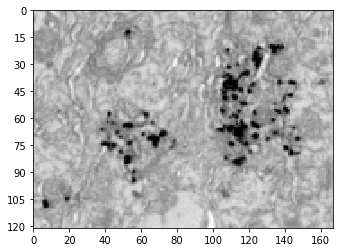

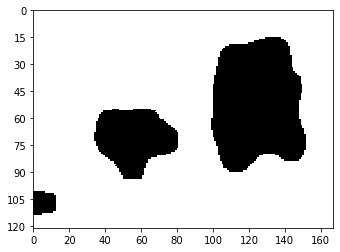

In [35]:
threshold1 = 90  # measured manually on the dense staining particles, for example using Image/Fiji.
closing_size = 12
box_filter_half_width = 6
threshold2 = 220

golgi = read_image('images/golgi-crop.png')
segmented_golgi = segment_golgi_stained_image(golgi, threshold1, closing_size, box_filter_half_width, threshold2)

viz(golgi, is_binary=False, show_pixel_edges=False)
viz(segmented_golgi, show_pixel_edges=False)

We can also display the original image with the segmentation mask transparently on top, like this:

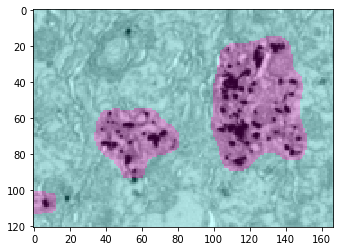

In [36]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(golgi, 'gray', interpolation='none')
plt.imshow(segmented_golgi, 'cool', interpolation='none', alpha=0.2)
plt.show()

Finally, below we show the images generated by the different processing steps in the algorithm. From top to bottom, left to right: the input image; the thresholded image with the dense metal precipitate, the closed version with the precipitate joined into a contiguous region, the box filtered version of this showing are more smooth boundary; the thresholded version of this which is the actual segmentation result; and an overlay showing the input EM image and the segmentation mask on top.

<div>
<img src="images/segm_result_a_input.png" width="150"/>
<img src="images/segm_result_b_stain.png" width="150"/>
<img src="images/segm_result_c_closed.png" width="150"/>
<img src="images/segm_result_d_box_filtered.png" width="150"/>
<img src="images/segm_result_e_mask.png" width="150"/>
<img src="images/segm_result_f_overlay.png" width="150"/>
</div>

Congratulations for making it this far! It's been a wild ride, but you can be proud of what you accomplished. You've implemented a non-trivial image processing pipeline with your bare hands!

Good luck with your future programming endeavors!

---

## References

Book: *Hands-on Morphological Image Processing*, Edward R. Dougherty, Roberto A. Lotufo, 2003

---